# Milestone 1: Group 17
Authors: Rus Dimitrov, Elena Ganacheva, Luke Yang, Shirley Zhang

In [28]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd

In [8]:
# Set up data source directory *Needs to be set up differently for each group member*
%cd \Users\Leny\Documents\MDS\DSCI_525\DSCI-525-Group-17

c:\Users\Leny\Documents\MDS\DSCI_525\DSCI-525-Group-17


## Downloading the data

In [9]:
# Necessary metadata
article_id = 14096681  
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "data/"

In [10]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text) 
files = data["files"]            
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

In [11]:
%%time
files_to_dl = ["data.zip"]
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: total: 5.67 s
Wall time: 1min 47s


In [12]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: total: 20.7 s
Wall time: 1min 5s


## Combining data CSVs

In [14]:
%%time
# Combine csv files into one pandas data frame
files = glob.glob('data/*.csv')
df = pd.concat((pd.read_csv(file, index_col=0)
                .assign(model=file.split('\\')[1].split('_')[0]) # needs to be changed from / to \\ for Windows
                for file in files)
              )
df.to_csv("data/combined_data.csv")

CPU times: total: 9min 39s
Wall time: 10min 19s


> Please see chart below for all times for all team members for both Q4 and Q5 as well as comments on our observations

## Load the combined CSV to memory and perform a simple EDA

In [15]:
%%time
# Trying to load in chunks and filter for values after 2000 and greater than 1
counts = pd.Series(dtype=int)
for chunk in pd.read_csv("data/combined_data.csv", chunksize=10_000_000):
    chunk['time'] = pd.to_datetime(chunk['time'])
    counts = counts.add(chunk[(chunk['time'] >=pd.to_datetime(2000)) & (chunk['rain (mm/day)'] >1)]["rain (mm/day)"].value_counts(), fill_value=0)
print(counts.astype(int))

1.000001      1
1.000003      1
1.000003      1
1.000003      1
1.000003      1
             ..
276.016970    1
279.512002    1
316.547388    1
321.963371    1
432.939515    1
Length: 4896937, dtype: int32
CPU times: total: 2min 25s
Wall time: 2min 28s


In [16]:
%%time
# EDA (decided to focus only on the rain column and values greater than 10 as "rainy days")
count_rainy_days = pd.Series(dtype=int)
for chunk in pd.read_csv("data/combined_data.csv", chunksize=10_000_000, usecols=["rain (mm/day)"]):
    count_rainy_days = count_rainy_days.add(chunk[(chunk > 10)], fill_value=0)

count_rainy_days = count_rainy_days.dropna()
print((count_rainy_days))

          rain (mm/day)
10000018      23.470050
10000054      24.661541
10000058      10.849851
10000059      10.113730
10000083      21.826647
...                 ...
62513833      14.118380
62513835      11.112642
62513836      51.232331
62513845      15.899770
62513846      25.125585

[2576194 rows x 1 columns]
CPU times: total: 1min 32s
Wall time: 1min 40s


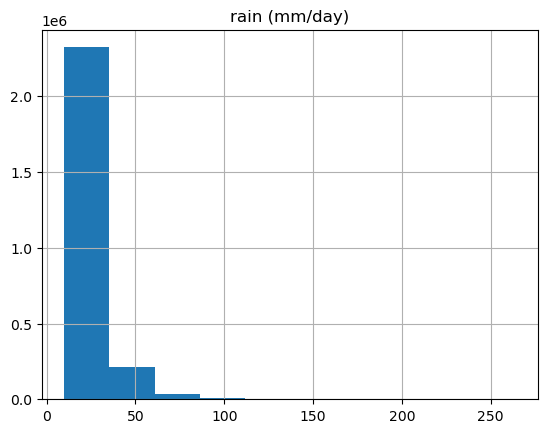

In [18]:
count_rainy_days.hist();

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken Q4|Time taken Q5|
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|:----------:|
| Shirley    |   Mac M2               |  8GB   |  Apple M2         |    TRUE    | 3min 15s           |    53.8s      |
| Luke    |MacOS|8GB|Apple M2|TRUE|3min 48s|1min 42s|
| Elena    |     Windows 10 Education             |  8GB   |   Intel Core i5-10210U       |  TRUE      |  9min 39s          |  1min 32s        |
| Ruslan    |   Windows 10               |  8GB   |     AMD Ryzen 7      |      TRUE  |  10min 22s          |   2min 55s       |

### Observations

It seems that the processors and potentially the operating systems have an impact on the time taken to execute the downloading of the data and the EDA. We were not able to access the impact of RAM as we all have 8GB of RAM. More specifically, downloading the data took three times as long on the Windows devices than the Mac devices, but this is most likely due to the Apple M2 processor being more powerful than the processors of our Windows devices than the operating systems themselves. When it came to the EDA our differences were smaller, with the split between Windows and Mac devices disappearing as Elena's computer was able to complete it slightly faster than Luke's while Ruslan's was the slowest and Shirley's was the fastest. There must be other factors in play that we did not record that account for the differences in processing for the EDA. 

## Perform a simple EDA in R

In [4]:
%load_ext rpy2.ipython

R[write to console]: Error in gettext(fmt, domain = domain, trim = trim) : 
  3 arguments passed to .Internal(gettext) which requires 2



RRuntimeError: Error in gettext(fmt, domain = domain, trim = trim) : 
  3 arguments passed to .Internal(gettext) which requires 2


In [26]:
%%R
suppressMessages(library(dplyr))
suppressMessages(library(readr))
suppressMessages(library(ggplot2))

UsageError: Cell magic `%%R` not found.


In [ ]:
%%R -i count_rainy_days
head(count_rainy_days)



- We chose to use 'Pandas Exchange' (converting from pandas dataframe to R)
- This is because we wanted the notebook to run by itself from top to bottom
- If we used a method like 'Parquet', we would be reading the .csv file twice (once for the Python EDA, and another time for the R EDA)
- This would take up a lot of memory, and the notebook would likely not be able to run fully
- Furthermore, we decided to use 'Pandas Exchange' instead of 'Pyarrow' as the latter does not use pandas dataframes. Instead, it creates a unified format that is shared between Python and R. However, we still wanted to use pandas for our Python EDA (due to familiarity). Thus, we thought 'Pandas Exchange' would be more appropriate.


In [ ]:
%%R
summary(count_rainy_days)

In [ ]:
%%time
%%R
ggplot(count_rainy_days) +
    geom_histogram(aes(x = `rain (mm/day)`))